In [ ]:
import os
import struct
import pickle
import shutil
from random import random
from typing import List

import numpy as np
# Okay, this is for using GPU POWEEEER
# import cupy as cp
import matplotlib.pyplot as plt
from jupyterlab.semver import hyphen_replace
from scipy.signal import freqs

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# print(cp.cuda.runtime.getDeviceCount())

# Reading Data

In [ ]:
def load_images(path: str):
    # Images in 784x1 format
    images = []
    
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n, rows, cols = struct.unpack('>IIII', f.read(16))
        
        for _ in range(n):
            # Read and unpack image (which has 28x28 bytes)
            image = list(struct.unpack('>' + 'B' * (rows * cols), f.read(rows * cols)))
            images.append(image)
    
    return np.array(images)

In [ ]:
def load_labels(path: str):
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n = struct.unpack('>II', f.read(8))
        
        # Read and return labels
        return np.array(struct.unpack('>' + 'B' * n, f.read(n)))

In [ ]:
def save_file(path, data):
    with open(path, 'wb') as f:
        f.write(data)

In [ ]:
train_images_path = "train-images.idx3-ubyte"
train_labels_path = "train-labels.idx1-ubyte"
test_images_path = "t10k-images.idx3-ubyte"
test_labels_path = "t10k-labels.idx1-ubyte"

train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

## Whitening (Z-Scoring) data

In [ ]:
def z_score(data):
    mean = np.mean(data)
    std = np.std(data)
    return mean, std, (data - mean) / std

In [ ]:
mean, std, train_images = z_score(train_images)

In [ ]:
test_images = (test_images - mean) / std

In [ ]:
save_file("preprocessed_data/train_images", train_images)
save_file("preprocessed_data/test_images", test_images)

# Re-shape and Visualization

In [ ]:
def reshape_matrix_to_images(matrix_images):
    apply_function = lambda row: row.reshape((28, 28))
    return np.apply_along_axis(apply_function, axis=1, arr=matrix_images)

In [ ]:
def plot_image(reshaped_image, label = ""):
    plt.imshow(reshaped_image, cmap=plt.get_cmap('gray'))
    if label != "":
        plt.title(f"Label: {label}")
    plt.show()

## Checking image-label pair

In [ ]:
reshaped_images = reshape_matrix_to_images(train_images)
rand_index = np.random.randint(0, len(train_images))
plot_image(reshaped_images[rand_index], train_labels[rand_index])

In [541]:
def one_hot_encoding(labels):
    one_hot_encoded_labels = []
    for i, label in enumerate(labels):
        one_hot_label = np.zeros(len(np.unique(labels)))
        one_hot_label[label] = 1.0
        one_hot_encoded_labels.append(one_hot_label)
    
    return np.array(one_hot_encoded_labels)

In [542]:
def one_hot_decoding(one_hot_encoded_labels):
    if len(one_hot_encoded_labels.shape) == 1:
        return np.argmax(one_hot_encoded_labels)
    return np.argmax(one_hot_encoded_labels, axis=1)

In [ ]:
train_encoded_labels = one_hot_encoding(train_labels)
test_encoded_labels = one_hot_encoding(test_labels)

## Checking 'one_hot_encoding' and 'one_hot_decoding' functions working correct

In [ ]:
train_encoded_labels[8:10]

In [ ]:
train_labels[8:10]

In [ ]:
one_hot_decoding(train_encoded_labels[8:10])

# NN

## Activation Functions

In [674]:
from abc import ABC, abstractmethod


class ActivationFunction(ABC):
    def __init__(self, cuda=False):
        self.cuda = cuda
    
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def derivatives(self, x):
        pass

class Relu(ActivationFunction):
    def forward(self, x):
        # if self.cuda:
        #     return cp.maximum(0, x)
        
        return np.maximum(x, 0)
    
    def derivatives(self, x):
        # if self.cuda:
        #     x = cp.asarray(x)
        
        return x > 0

class Softmax(ActivationFunction):
    def forward(self, x):
        # if self.cuda:
        #     x = cp.asarray(x)
        #     exps = cp.exp(x - cp.max(x))
        #     return exps / cp.sum(exps)
            
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)
    
    def derivatives(self, x):
        # This is not implemented because we use cross-categorical loss and we skip this step
        return 1

class Tanh(ActivationFunction):
    def forward(self, x):
        return np.tanh(x)

    def derivatives(self, x):
        return 1 - (x ** 2)

## Weight Initializers

In [675]:
class WeightInitializer(ABC):
    @abstractmethod
    def init(self, n_in, n_out, cuda=False):
        pass
    
class NormalInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        # if cuda:
        #     return cp.random.standard_normal(size=(n_in, n_out))
        
        return np.random.standard_normal(size=(n_in, n_out))
    
class XavierInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        # if cuda:
        #     return cp.random.normal(0, 1/n_in, size=(n_in, n_out))
        
        return np.random.normal(0, 1/n_in, size=(n_in, n_out))

# Weights initializer from given research paper and yes, it works SUPER
class PaperInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        # if cuda:
        #     return cp.random.normal(0, np.sqrt(2/n_in), size=(n_in, n_out))
        
        return np.random.normal(0, np.sqrt(2/n_in), size=(n_in, n_out))
    
class ZeroInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        # if cuda:
        #     return cp.zeros((n_in, n_out))
        return np.zeros((n_in, n_out))
    
class VeryLargeInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        # if cuda:
        #     return cp.random.normal(1000, 500, size=(n_in, n_out))
        return np.random.normal(1000, 500, size=(n_in, n_out))

## Optimizers

In [1942]:
class Optimizer(ABC):
    def __init__(self, cuda=False):
        self.weights = None
        self.bias = None
        self.cuda = cuda
                    # print(f"Loss (train) {epoch }: {avg_train_loss}")
                # print(f"Loss (test) {epoch}: {avg_test_loss}")
    def set_weights_and_bias(self, weights, bias):
        self.weights = weights
        self.bias = bias
        
    def convert_to_cupy_array(self, dW, db):
        # return cp.asarray(dW), cp.asarray(db)
        pass
    
    @abstractmethod
    def optimize(self, hyperparams, dW, db):
        pass

class SGD(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.weights -= lr * dW
        self.bias -= lr * db

class Momentum(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.v = 0
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta = hyperparams["beta1"]
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.v = beta * self.v + (1 - beta) * dW

        self.weights -= lr * self.v
        self.bias -= lr * db
        
class RMSProp(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.s = 0
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta2 = hyperparams['beta2']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        dW = dW ** 2
        
        self.s = beta2 * self.s + (1 - beta2) * dW
        
        self.weights -= lr * dW / np.sqrt(self.s + 1e-10)
        self.bias -= lr * db
        
class Adam(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.v = 0
        self.s = 0
        
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta1 = hyperparams['beta1']
        beta2 = hyperparams['beta2']
        epochs = hyperparams['epochs']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.v = beta1 * self.v + (1 - beta1) * dW
        self.s = beta2 * self.s + (1 - beta2) * dW**2
        
        self.weights -= lr * self.v / (np.sqrt(self.s) + 1)
        self.bias -= lr * db
        
        self.v = self.v / (1.0 - np.pow(beta1, epochs))
        self.s = self.s / (1.0 - np.pow(beta2, epochs))

## Loss Functions

In [1904]:
class LossFunction(ABC):
    def __init__(self, cuda=False):
        self.cuda = cuda
    
    @abstractmethod
    def loss(self, y_pred, y_true):
        pass
    
    @abstractmethod
    def gradient(self, y_pred, y_true):
        pass

class MSE(LossFunction):
    def __init__(self, cuda=False):
        super().__init__(cuda)
    
    def loss(self, y_pred, y_true):
        # if self.cuda:
        #     return cp.mean((y_pred - y_true) ** 2)
        
        return np.sum((y_pred - y_true) ** 2) / 2
    
    def gradient(self, y_pred, y_true):
        return (y_pred - y_true)
    
class CategoricalCrossEntropy(LossFunction):
    def __init__(self, cuda=False):
        super().__init__(cuda)
    
    def loss(self, y_pred, y_true):
        # if self.cuda:
        #     return -cp.sum(y_pred * cp.log(y_pred + 1e-8))
        
        return -np.sum(y_pred * np.log(y_pred + 1e-8))
    
    def gradient(self, y_pred, y_true):
        # This gradient is only with Softmax
        return y_pred - y_true

In [713]:
from abc import ABC, abstractmethod


class Layer(ABC):
    def __init__(self,n_in, n_out, is_output = False,
                 weight_init: WeightInitializer = NormalInitializer(),
                 activation: str = "relu",
                 optimizer: str = "momentum",
                 cuda: bool = False,
                 need_flatten=False):
        self.n_in = n_in
        self.n_out = n_out
        self.is_output = is_output
        self.weight_init = weight_init
        self.activation = activation
        self.optimizer = optimizer
        self.cuda = cuda
        self.need_flatten = need_flatten
        
        self.A_prev = None
        self.Z = None
        
        self.Z_mean = None
        self.Z_std = None
        
        self.v = 0
    
    def _get_module(self):
        # if self.cuda:
        #     return cp
        return np
    
    @abstractmethod
    def forward(self, A_prev, is_training = True):
        pass
    
    @abstractmethod
    def backprop(self, dZ_prev, m, is_batch_mode=False):
        pass
    
    @abstractmethod
    def update(self, hyperparams, dW, db):
        pass

In [679]:
class DenseLayer(Layer):
    def __init__(self, n_in, n_out, is_output = False,
                 weight_init: WeightInitializer = PaperInitializer(),
                 activation: str = "relu",
                 optimizer = "momentum",
                 cuda=False,
                 need_flatten=False):
        super().__init__(n_in, n_out, is_output, weight_init, activation, optimizer, cuda, need_flatten)
        
        self.activation = self.activation.lower()
        if activation == "relu":
            self.activation = Relu(self.cuda)
        elif activation == "softmax":
            self.activation = Softmax(self.cuda)
        
        self.optimizer = self.optimizer.lower()
        if optimizer == "sgd":
            self.optimizer = SGD(self.cuda)
        elif optimizer == "momentum":
            self.optimizer = Momentum(self.cuda)
        elif optimizer == "rmsprop":
            self.optimizer = RMSProp(self.cuda)
        elif optimizer == "adam":
            self.optimizer = Adam(self.cuda)

        self.weights = self.weight_init.init(n_in, n_out, self.cuda)
        
        if self.cuda:
            # self.bias = cp.zeros((1, n_out))
            pass
        else:
            self.bias = np.zeros((1, n_out))
        
        self.optimizer.set_weights_and_bias(self.weights, self.bias)
    
    def forward(self, A_prev, is_training = True):
        if self.need_flatten:
            A_prev = A_prev.flatten()
            A_prev = A_prev.reshape((1, A_prev.shape[0]))
        self.A_prev = A_prev
        
        module = self._get_module()
        
        self.Z = module.dot(A_prev, self.weights) + self.bias
        
        if is_training and self.Z.shape[0] != 1:
            self.Z_mean = module.mean(self.Z, axis = 0)
            self.Z_std = module.std(self.Z, axis = 0)

        if self.Z_mean is not None and self.Z_std is not None:    
            self.Z = (self.Z - self.Z_mean) / self.Z_std
            
        return self.activation.forward(self.Z)

    def backprop(self, dZ_prev, m, is_batch_mode=False):
        dZ = dZ_prev * self.activation.derivatives(self.Z)
        
        module = self._get_module()
        
        if is_batch_mode:
            dW = 0
            dZ_next = []
            for i in range(dZ_prev.shape[0]):
                dW += 1/m * module.dot(self.A_prev[:,i], dZ[i,:])
                dZ_next.append(module.dot(dZ[i,:], self.weights.T))
            
            dW /= dZ_prev.shape[0]
            dZ_next = module.vstack(tuple(dZ_next))
        else:
            dW = 1/m * module.dot(self.A_prev.T, dZ)
            dZ_next = module.dot(dZ, self.weights.T)
        
        db = 1/m * module.sum(dZ, axis=0, keepdims=True) / dZ_prev.shape[0]
        
        return dZ_next, dW, db
    
    def update(self, hyperparams, dW, db):
        self.optimizer.optimize(hyperparams, dW, db)

In [680]:
class CNN(Layer):
    def __init__(self, n_in, n_out, n_filters, is_output = False,
                 weight_init: WeightInitializer = NormalInitializer(),
                 activation: str = "relu",
                 optimizer = "momentum",
                 cuda=False):
        super().__init__(n_in, n_out, is_output, weight_init, activation, optimizer, cuda)
        
        self.n_filters = n_filters
        self.filter_row_size = n_in[0] - n_out[0] + 1
        self.filter_col_size = n_in[1] - n_out[1] + 1
        
        if self.cuda:
            # self.weights = cp.random.randn(self.n_filters, self.filter_row_size, self.filter_col_size) / 9
            pass
        else:
            self.weights = np.random.randn(self.n_filters, self.filter_row_size, self.filter_col_size) / 9
        
    def _get_segment(self, input):
        for i in range(self.n_out[0]):
            for j in range(self.n_out[1]):
                segment = input[i:(i + self.filter_row_size), j:(j + self.filter_row_size)]
                yield segment, i, j
    
    def forward(self, A_prev, is_training = True):
        if A_prev.shape != self.n_in:
            A_prev = A_prev.reshape(self.n_in)
        self.A_prev = A_prev
            
        module = self._get_module()
        
        output = module.zeros((self.n_out[0], self.n_out[1], self.n_filters))
        for segment, i, j in self._get_segment(A_prev):
            output[i, j] = module.sum(segment * self.weights, axis=(1, 2))
        
        return output
    
    def backprop(self, dZ_prev, m, is_batch_mode=False):
        module = self._get_module()
        
        dW = module.zeros(self.weights.shape)
        for segment, i, j in self._get_segment(self.A_prev):
            for _filter in range(self.n_filters):
                dW[_filter] += dZ_prev[i, j, _filter] * segment
        
        return None, dW, None
    
    def update(self, hyperparams, dW, db):
        learning_rate = hyperparams['learning_rate']
        self.weights -= learning_rate * dW

In [681]:
class MaxPoolLayer(Layer):
    def __init__(self, n_in, n_out, n_filters, is_output = False,
                 optimizer = "momentum",
                 cuda=False):
        super().__init__(n_in, n_out, is_output, None, "", optimizer, cuda)
        
        self.n_filters = n_filters
        self.factor = n_in[0] // n_out[0]
    
    def _get_segment(self, input):
        for i in range(self.n_out[0]):
            for j in range(self.n_out[1]):
                _i = i * self.factor
                _j = j * self.factor
                segment = input[_i:(_i + self.factor), _j:(_j + self.factor)]
                yield segment, i, j
    
    def forward(self, A_prev, is_training = True):
        self.A_prev = A_prev
        
        module = self._get_module()
        
        output = module.zeros((self.n_out[0], self.n_out[1], self.n_filters))
        for segment, i, j in self._get_segment(A_prev):
            output[i, j] = module.amax(segment, axis=(0, 1))
            
        return output
    
    def backprop(self, dZ_prev, m, is_batch_mode=False):
        dZ_prev = dZ_prev.reshape((self.n_out[0], self.n_out[1], self.n_filters))
        dZ = np.zeros(self.A_prev.shape)
        
        module = self._get_module()
        
        for segment, i, j, in self._get_segment(self.A_prev):
            row, col, _filter = segment.shape
            max_val = module.amax(segment, axis=(0, 1))
            
            for ii in range(row):
                for jj in range(col):
                    for kk in range(_filter):
                        if segment[ii, jj, kk] == max_val[kk]:
                            dZ[i * self.factor + ii, j * self.factor + jj, kk] = dZ_prev[i, j, kk]
        
        return dZ, None, None
                            
    
    def update(self, hyperparams, dW, db):
        pass

In [682]:
class NN:
    def __init__(self, layers: List[Layer], hyperparams: dict, loss_function: LossFunction, cuda=False):
        self.layers = layers
        self.layers[-1].is_output = True
        
        self.hyperparams = hyperparams
        
        self.loss_function = loss_function
        
        self.cuda = cuda
    
    def forward(self, X, is_training = True):
        # if self.cuda:
        #     X = cp.asarray(X)
        
        if len(X.shape) == 1:
            A_prev = X.reshape((1, X.shape[0]))
        else:
            A_prev = X
            
        for layer in self.layers:
            A_prev = layer.forward(A_prev, is_training)
        
        return A_prev
    
    def backprop(self, y_pred, y_true, is_batch_mode=False):
        # if self.cuda:
        #     y_pred = cp.asarray(y_pred)
        #     y_true = cp.asarray(y_true)
        
        dZ = self.loss_function.gradient(y_pred, y_true)
        
        for layer in self.layers[::-1]:
            dZ, dW, db = layer.backprop(dZ, y_true.shape[0], is_batch_mode)
            layer.update(self.hyperparams, dW, db)
    
    def accuracy(self, y_pred, y_true):
        axis = len(y_true.shape) - 1
        decoded_y_pred = np.argmax(y_pred, axis = axis)
        decoded_y_true = np.argmax(y_true, axis = axis)
        return np.sum(decoded_y_pred == decoded_y_true) / y_true.shape[0]
    
    def train(self, train_set, train_label_set, test_set, test_label_set, epochs = 10000, is_batch_mode=False, batch_size=100, decay_step = 100, decay_rate = 0.96, save_path=None):
        # if self.cuda:
        #     train_set = cp.asarray(train_set)
        #     train_label_set = cp.asarray(train_label_set)
        #     test_set = cp.asarray(test_set)
        #     test_label_set = cp.asarray(test_label_set)
        
        self.hyperparams["epochs"] = epochs
        
        train_losses = []
        test_losses = []
        
        avg_train_loss = 0
        avg_test_loss = 0
        
        batch_count = train_set.shape[0] // batch_size
        
        for epoch in tqdm(range(epochs)):
            if is_batch_mode:
                rand_batch_idx = np.random.randint(0, batch_count - 1)
                start = rand_batch_idx * batch_size
                end = min((rand_batch_idx + 1) * batch_size, train_set.shape[0])
                X = train_set[start:end]
                y = train_label_set[start:end]
            else:
                rand_idx = np.random.randint(0, train_set.shape[0])
                X = train_set[rand_idx]
                y = train_label_set[rand_idx]
            
            y_pred = self.forward(X)
            
            training_loss = self.loss_function.loss(y_pred, y)
            avg_train_loss += training_loss
            
            self.backprop(y_pred, y)
            
            rand_idx = np.random.randint(0, test_set.shape[0])
            X_test = test_set[rand_idx]
            y_test = test_label_set[rand_idx]
            
            test_y_pred = self.forward(X_test, is_training = False)
            test_loss = self.loss_function.loss(test_y_pred, y_test)
            avg_test_loss += test_loss
            
            if epoch % decay_step == 0 and epoch > 0:
                self.hyperparams["learning_rate"] *= decay_rate
                
                avg_train_loss /= decay_step
                avg_test_loss /= decay_step
                
                if self.cuda:
                    test_losses.append(avg_test_loss.get())
                    train_losses.append(avg_train_loss.get())
                else:
                    test_losses.append(avg_test_loss)
                    train_losses.append(avg_train_loss)
                
                avg_train_loss = 0
                avg_test_loss = 0
                
                if save_path is not None:
                    with open(save_path + "/" + f"NN_{epoch}", "wb") as f:
                        pickle.dump(self, f)
                        
        
        avg_train_loss /= decay_step
        avg_test_loss /= decay_step
        
        if self.cuda:
            test_losses.append(avg_test_loss.get())
            train_losses.append(avg_train_loss.get())
        else:
            test_losses.append(avg_test_loss)
            train_losses.append(avg_train_loss)
        
        if save_path is not None:
            with open(save_path + "/" + f"NN_{epochs}", "wb") as f:
                pickle.dump(self, f)
        
        return train_losses, test_losses

## Experiment Manager

In [383]:
class ExperimentManager:
    def __init__(self, experiment_folder: str):
        self.experiment_name = os.path.abspath('.') + "/" + experiment_folder
        
        if os.path.isdir(self.experiment_name):
            shutil.rmtree(self.experiment_name)
            
        os.mkdir(self.experiment_name)
        os.mkdir(self.experiment_name + "/weights")
        
        self.train_set = None
        self.train_label_set = None
        self.validation_set = None
        self.validation_label_set = None
        self.test_set = None
        self.test_label_set = None
    
    def load_data(self, train_data, train_labels, test_data, test_labels, train_portion = 0.75):
        perm = np.random.permutation(train_images.shape[0])
        
        self.train_set = train_data[perm[:int(train_portion * train_data.shape[0])]]
        self.train_label_set = train_labels[perm[:int(train_portion * train_labels.shape[0])]]
        
        self.validation_set = train_data[perm[int(train_portion * train_data.shape[0]):]]
        self.validation_label_set = train_labels[perm[int(train_portion * train_labels.shape[0]):]]
        
        self.test_set = test_data
        self.test_label_set = test_labels
    
    def load_nn(self, path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    
    def results_on_test(self, nn):
        cuda = nn.cuda
        
        output = []
        for test_value in tqdm(self.test_set):
            output_value = nn.forward(test_value, is_training = False)
            if cuda:
                output_value = output_value.get()
            output.append(output_value.flatten())
        
        output = np.array(output)
        acc = nn.accuracy(output, test_encoded_labels)
        output = one_hot_decoding(output)
        
        cf_matrix = confusion_matrix(test_labels, output)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
        cm_display.plot()
        plt.suptitle(f"Accuracy on test set: {acc * 100:.2f}%")
        plt.savefig(self.experiment_name + '/' + 'results.png')
    
    def save_weights(self, nn, n = 10):
        for i in range(n):
            if nn.cuda:
                weights = nn.layers[0].weights[:,i].reshape((28, 28)).get()
            else:
                weights = nn.layers[0].weights[:,i].reshape((28, 28))
            
            plt.imshow(weights, cmap=plt.get_cmap('gray'))
            plt.savefig(self.experiment_name + '/weights/' + f'weight_{i + 1}.png')
            plt.clf()
    
    def experiment(self, nn: NN, epochs = 10000, is_batch_mode=False, batch_size=100, decay_step = 100, decay_rate = 0.96):
        train_losses, validation_losses = nn.train(self.train_set, self.train_label_set, self.validation_set, self.validation_label_set,
                                                   epochs, is_batch_mode, batch_size, decay_step, decay_rate,
                                                   save_path = self.experiment_name)
        plt.plot(range(0, epochs, decay_step), train_losses, label='train')
        plt.plot(range(0, epochs, decay_step), validation_losses, label='validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig(self.experiment_name + '/' + 'loss.png')
        plt.show()
        
        # self.save_weights(nn)
        self.results_on_test(nn)

## Initialization of NN with distinct params (code testing)

In [135]:
epochs = 60000
decay_step = epochs // 10

hyperparams = {
    "learning_rate": 0.01,
    "beta1": 0.9,
    "beta2": 0.999,
}

is_batch_mode = False
batch_size = 100

cuda = False

nn = NN(layers=[
    CNN((28, 28), (26, 26), 8, cuda=cuda),
    MaxPoolLayer((26, 26), (13, 13), 8, cuda=cuda),
    DenseLayer(1352, 10, activation="softmax", cuda=cuda, optimizer="momentum", need_flatten=True),
], hyperparams=hyperparams, loss_function=CategoricalCrossEntropy(cuda), cuda=cuda)

In [136]:
em = ExperimentManager("cnn_60000_it")
em.load_data(train_images, train_encoded_labels, test_images, test_encoded_labels)
em.experiment(nn, epochs = epochs, is_batch_mode = is_batch_mode, batch_size = batch_size, decay_step=decay_step)

NameError: name 'train_images' is not defined

In [137]:
occlusion_window_size = (3, 3)

In [138]:
def get_modified_images(images, labels, window_size, n = 3):
    images_dict = {}
    
    def get_n_label_images(search_label):
        nonlocal labels, n, images, images_dict
        result = []
        for i, label in enumerate(labels):
            if label == search_label:
                if len(result) == n:
                    break
                result.append(images[i])
        
        images_dict[search_label] = result
    
    for i in range(10):
        get_n_label_images(i)
    
    modified_images = {}
    for key, _images in images_dict.items():
        modified_images[key] = []
        for image in _images:
            image = image.reshape((28, 28))
            for i in range(28 - window_size[0] + 1):
                for j in range(28 - window_size[1] + 1):
                    copy_image = image.copy()
                    copy_image[i:(i + window_size[0]), j:(j + window_size[1])] = 0
                    modified_images[key].append(copy_image)
    
    return modified_images

In [ ]:
images_dict = get_modified_images(train_images, train_labels, occlusion_window_size)

In [ ]:
len(images_dict[0])

In [ ]:
prob_dict = {}
for i in range(10):
    prob_dict[i] = []

In [ ]:
for key, _images in tqdm(images_dict.items()):
    for im in tqdm(_images):
        im = im.flatten()
        prob_dict[key].append(
            nn.forward(im)[0][key]
        )

In [ ]:
plt.style.use('classic')
for key, probs in prob_dict.items():
    probs = np.array(probs).reshape((3, 26, 26))
    for i in range(3):
        occlusion_im = probs[i,:,:]
        plt.imshow(occlusion_im, cmap=plt.get_cmap('gray'))
        plt.savefig(f"occlusions_3x3/{key}/{i}.png")
        plt.show()
    
    prob = np.average(probs, axis = 0)
    plt.imshow(prob, cmap=plt.get_cmap('gray'))
    plt.savefig(f"occlusions_3x3/avg_version/{key}.png")
    plt.show()

# RNN

In [384]:
np.random.seed(42)
def get_sine_with_noice(freq, time, mean, std):
    length = np.pi * 2 * time
    sample = np.arange(0, length, length/freq)
    return np.sin(sample) + np.random.normal(mean, std, len(sample))

In [385]:
freq = 10001
time = 10
noise_mean = 0
noise_std = 0.1
sine_wave = get_sine_with_noice(freq, time, noise_mean, noise_std)
time_array = np.arange(0, freq) / freq * time
print(len(sine_wave))
print(len(time_array))

10001
10001


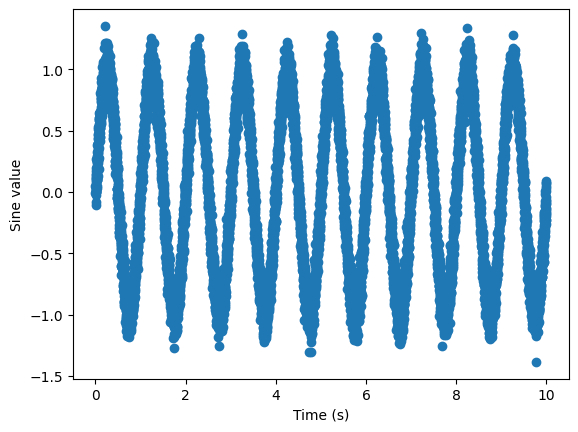

In [386]:
plt.scatter(time_array, sine_wave)
plt.xlabel('Time (s)')
plt.ylabel('Sine value')
plt.show()

In [387]:
train_set = []
train_label_set = []
for i in range(0, 10000, 10):
    train_set.append([sine_wave[i:i+10]])
    train_label_set.append([sine_wave[i+10]])
train_set = np.array(train_set)
train_label_set = np.array(train_label_set)

print(train_set.shape)
print(train_label_set.shape)

(1000, 1, 10)
(1000, 1)


In [388]:
epochs = 100000
hyperparams = {
    "learning_rate": 0.0001,
    "beta1": 0.9,
    "beta2": 0.999,
}
cuda = False

nn = NN(layers=[
    DenseLayer(10, 8, optimizer="adam"),
    DenseLayer(8, 5, optimizer="adam"),
    DenseLayer(5, 1, optimizer="adam"),
], hyperparams=hyperparams, loss_function=MSE(cuda=cuda), cuda=cuda)

In [389]:
nn.train(train_set, train_label_set, train_set, train_label_set, epochs)

  0%|          | 0/100000 [00:00<?, ?it/s]

([np.float64(0.256936832485812),
  np.float64(0.25551814995013533),
  np.float64(0.2692078184997133),
  np.float64(0.242250411225039),
  np.float64(0.24059028587929318),
  np.float64(0.23502114350659173),
  np.float64(0.2398492796642196),
  np.float64(0.2602497517630488),
  np.float64(0.23393263085804444),
  np.float64(0.2685848994131462),
  np.float64(0.25956863626423976),
  np.float64(0.24976231495518783),
  np.float64(0.24174206330814535),
  np.float64(0.2721878812621775),
  np.float64(0.24059575309383802),
  np.float64(0.2501106199694695),
  np.float64(0.25926548692022405),
  np.float64(0.26536172203760156),
  np.float64(0.27179555628762864),
  np.float64(0.2378139811777621),
  np.float64(0.24162314556551068),
  np.float64(0.23278508490835978),
  np.float64(0.2628992193870389),
  np.float64(0.25877054459394494),
  np.float64(0.25065743465474843),
  np.float64(0.2701791053030077),
  np.float64(0.23539121150311698),
  np.float64(0.2609307912238252),
  np.float64(0.2716678117817431),


In [411]:
predicted_values = nn.forward(train_set)
predicted_values.shape

(1000, 1, 1)

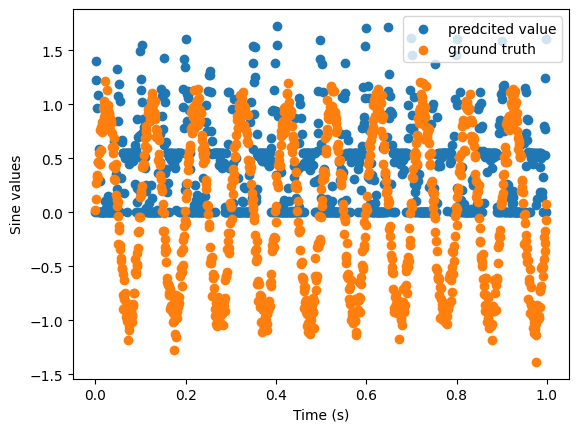

In [412]:
plt.scatter(time_array[:1000], predicted_values, label="predcited value")
plt.scatter(time_array[:1000], train_label_set, label="ground truth")
plt.xlabel('Time (s)')
plt.ylabel('Sine values')
plt.legend()
plt.show()

In [1920]:
class RNN(Layer):
    def __init__(self, n_in, n_hidden, n_out, is_output = False,
                 weight_init: WeightInitializer = NormalInitializer(),
                 activation: str = "relu",
                 optimizer: str = "momentum",
                 cuda: bool = False,
                 need_flatten=False):
        super().__init__(n_in, n_out, is_output, weight_init, activation, optimizer, cuda, need_flatten)
        self.n_hidden = n_hidden

        self.activation = self.activation.lower()
        if activation == "relu":
            self.activation = Relu(self.cuda)
        elif activation == "softmax":
            self.activation = Softmax(self.cuda)
        elif self.activation == "tanh":
            self.activation = Tanh(self.cuda)

        self.optimizer = self.optimizer.lower()
        if optimizer == "sgd":
            self.optimizer_in = SGD(self.cuda)
            self.optimizer_hidden = SGD(self.cuda)
            self.optimizer_output = SGD(self.cuda)
        elif optimizer == "momentum":
            self.optimizer_in = Momentum(self.cuda)
            self.optimizer_hidden = Momentum(self.cuda)
            self.optimizer_output = Momentum(self.cuda)
        elif optimizer == "rmsprop":
            self.optimizer_in = RMSProp(self.cuda)
            self.optimizer_hidden = RMSProp(self.cuda)
            self.optimizer_output = RMSProp(self.cuda)
        elif optimizer == "adam":
            self.optimizer_in = Adam(self.cuda)
            self.optimizer_hidden = Adam(self.cuda)
            self.optimizer_output = Adam(self.cuda)

        self.w_in_hidden = self.weight_init.init(self.n_in, self.n_hidden, self.cuda)
        self.w_hidden_hidden = self.weight_init.init(self.n_hidden, self.n_hidden, self.cuda)
        self.w_hidden_out = self.weight_init.init(self.n_hidden, self.n_out, self.cuda)

        module = self._get_module()
        self.bias_in = module.zeros((1, self.n_in))
        self.bias_hidden = module.zeros((1, self.n_hidden))
        self.bias_output = module.zeros((1, self.n_out))

        self.optimizer_in.set_weights_and_bias(self.w_in_hidden, self.bias_in)
        self.optimizer_hidden.set_weights_and_bias(self.w_hidden_hidden, self.bias_hidden)
        self.optimizer_output.set_weights_and_bias(self.w_hidden_out, self.bias_output)

        self.A_prev = None
        self.hidden_states = None

        self.d_bias_output = None
        self.d_w_hidden_output = None
        self.d_bias_hidden = None
        self.d_w_hidden_hidden = None
        self.d_w_in_hidden = None
        self.d_hidden_state = None

    def forward(self, A_prev, use_soft_max=False, is_training=True):
        self.A_prev = np.copy(A_prev)
        self.hidden_states = [np.zeros((self.n_out, self.n_hidden))]

        for x in A_prev:
            l1_output = np.dot(x, self.w_in_hidden)
            l2_output = np.dot(self.hidden_states[-1], self.w_hidden_hidden) + self.bias_hidden

            self.hidden_states += [
                self.activation.forward(l1_output + l2_output),
            ]

        if use_soft_max:
            softmax_func = Softmax(self.cuda)
            return softmax_func.forward(np.dot(self.hidden_states[-1], self.w_hidden_out) + self.bias_output)

        return np.dot(self.hidden_states[-1], self.w_hidden_out) + self.bias_output

    def backprop(self, dZ_prev, m=None, is_batch_mode=False):
        self.d_bias_output = dZ_prev
        self.d_w_hidden_output = np.dot(self.hidden_states[-1].T, dZ_prev)

        self.d_bias_hidden = np.zeros_like(self.bias_hidden)
        self.d_w_hidden_hidden = np.zeros_like(self.w_hidden_hidden)
        self.d_w_in_hidden = np.zeros_like(self.w_in_hidden)

        self.d_hidden_state = np.dot(self.w_hidden_out, dZ_prev)
        for i in reversed(range(len(self.A_prev))):
            activated_grad = self.activation.derivatives(self.hidden_states[i + 1].T)
            self.d_hidden_state = self.d_hidden_state.reshape(activated_grad.shape)
            self.d_hidden_state *= activated_grad

            self.d_bias_hidden += np.mean(self.d_hidden_state, axis=1)
            self.d_w_hidden_hidden += np.dot(self.d_hidden_state, self.hidden_states[i])

            try:
                a = self.A_prev[i].reshape((1, self.A_prev[i].shape[0]))
                self.d_w_in_hidden += np.dot(a, self.d_hidden_state.T)
            except:
                a = self.A_prev[i].reshape((self.A_prev[i].shape[0], 1))
                self.d_w_in_hidden += np.dot(a, self.d_hidden_state.T)

            self.d_hidden_state = np.dot(self.d_hidden_state.T, self.w_hidden_hidden)

        # Clip the gradients
        for grad in [self.d_bias_output, self.d_w_hidden_output, self.d_bias_hidden, self.d_w_hidden_hidden, self.d_w_in_hidden]:
            np.clip(grad, -1, 1, out=grad)

        self.d_w_in_hidden = self.d_w_in_hidden.reshape(self.w_in_hidden.shape)
        self.d_w_hidden_hidden = self.d_w_hidden_hidden.reshape(self.w_hidden_hidden.shape)
        self.d_w_hidden_output = self.d_w_hidden_output.reshape(self.w_hidden_out.shape)

        if len(self.d_bias_output.shape) == 3:
            self.d_bias_output = np.mean(self.d_bias_output, axis=1)
        self.d_bias_hidden = self.d_bias_hidden.reshape(self.bias_hidden.shape)
        self.d_bias_output = self.d_bias_output.reshape(self.bias_output.shape)

    def update(self, hyperparams, dW=None, db=None):
        module = self._get_module()
        self.optimizer_in.optimize(
            hyperparams,
            self.d_w_in_hidden,
            module.zeros((1, self.n_in))
        )
        self.optimizer_hidden.optimize(
            hyperparams,
            self.d_w_hidden_hidden,
            self.d_bias_hidden
        )
        self.optimizer_output.optimize(
            hyperparams,
            self.d_w_hidden_output,
            self.d_bias_output
        )

In [1921]:
rnn = RNN(10, 5, 1, activation="tanh")

In [1922]:
epochs = 100
hyperparams = {
    "learning_rate": 0.0001,
    "beta1": 0.9,
    "beta2": 0.999,
}
cuda = False
activation_function = MSE()

for _ in tqdm(range(epochs)):
    for i, x in enumerate(train_set):
        y = train_label_set[i]
        y_pred = rnn.forward(x)
        error = activation_function.gradient(y_pred, y)
        rnn.backprop(error, None)
        rnn.update(hyperparams, None, None)

  0%|          | 0/100 [00:00<?, ?it/s]

In [1923]:
y_preds = []
for x in train_set:
    pred = rnn.forward(x)
    pred = pred.flatten()[0]
    y_preds.append(pred)
y_preds = np.array(y_preds)
print(y_preds.shape)
print(time_array[:10000].shape)

(1000,)
(10000,)


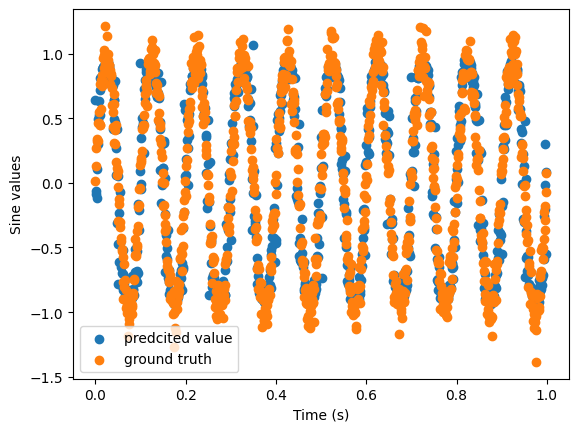

In [1924]:
plt.scatter(time_array[:1000], y_preds, label="predcited value")
plt.scatter(time_array[:1000], train_label_set, label="ground truth")
plt.xlabel('Time (s)')
plt.ylabel('Sine values')
plt.legend()
plt.show()

## Create Vocab

In [1964]:
import string

ascii_lower = string.ascii_lowercase
ascii_lower += "$"
ascii_lower

'abcdefghijklmnopqrstuvwxyz$'

In [1965]:
vocab = {}
inverse_vocab = {}
for i, letter in enumerate(ascii_lower):
    vocab[letter] = i
    inverse_vocab[i] = letter
one_hot_encoded_vocab = one_hot_encoding(range(0, len(vocab)))
vocab

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '$': 26}

## Load Dino dataset

In [1966]:
with open("dino_island.txt", "r", encoding="utf-8") as f:
    dino_island = list(map(lambda name: name.strip().lower() + "$", f.readlines())),
dino_island = np.array(dino_island).reshape(1546, 1)
dino_island

array([['aachenosaurus$'],
       ['aardonyx$'],
       ['abdallahsaurus$'],
       ...,
       ['zuoyunlong$'],
       ['zupaysaurus$'],
       ['zuul$']], dtype='<U24')

In [1967]:
encoded_dino_island = []
for dino_name in dino_island:
    dino_name = dino_name[0]
    encoded_name = []
    for letter in dino_name:
        encoded_name.append(vocab[letter])
    # Add padding
    encoded_name += [0] * (len(vocab) - len(dino_name))
    encoded_dino_island.append([encoded_name])
encoded_dino_island = np.array(encoded_dino_island)
encoded_dino_island

array([[[ 0,  0,  2, ...,  0,  0,  0]],

       [[ 0,  0, 17, ...,  0,  0,  0]],

       [[ 0,  1,  3, ...,  0,  0,  0]],

       ...,

       [[25, 20, 14, ...,  0,  0,  0]],

       [[25, 20, 15, ...,  0,  0,  0]],

       [[25, 20, 20, ...,  0,  0,  0]]])

In [1968]:
encoded_dino_island[0]

array([[ 0,  0,  2,  7,  4, 13, 14, 18,  0, 20, 17, 20, 18, 26,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [1969]:
rnn = RNN(len(vocab), 200, len(vocab), activation="tanh", optimizer="sgd")

In [1970]:
epochs = 10
hyperparams = {
    "learning_rate": 0.001,
    "beta1": 0.9,
    "beta2": 0.999,
    "epochs": 1
}
cuda = False

In [1971]:
loss_function = CategoricalCrossEntropy()
losses = []
for _ in tqdm(range(epochs)):
    inner_loss = []
    for encoded_dino_name in encoded_dino_island:
        encoded_true = []
        pred = rnn.forward(encoded_dino_name, use_soft_max=True)
        for i in range(len(encoded_dino_island[0])):
            encoded_true.append(
                one_hot_encoded_vocab[encoded_dino_island[0][i] - 1]
            )
        encoded_true = np.array(encoded_true)
        loss = loss_function.loss(pred, encoded_true)
        inner_loss.append(loss)
        grad = loss_function.gradient(pred, encoded_true)
        rnn.backprop(grad)
        rnn.update(hyperparams)
    hyperparams["epochs"] += 1
    hyperparams["learning_rate"] *= 0.96
    losses.append(np.mean(inner_loss))

  0%|          | 0/10 [00:00<?, ?it/s]

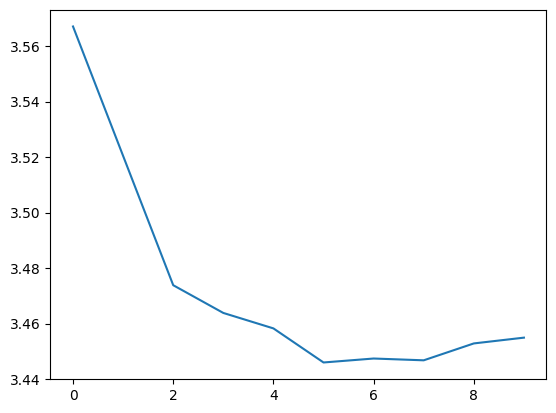

In [1972]:
plt.plot(range(epochs), losses)
plt.show()

In [1973]:
_pred = rnn.forward(encoded_dino_island[0], use_soft_max=True)
_pred

array([[0.00000000e+00, 6.87102988e-14, 0.00000000e+00, 2.50567331e-11,
        0.00000000e+00, 0.00000000e+00, 3.58982749e-11, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.60514695e-09, 3.72954230e-10, 0.00000000e+00, 0.00000000e+00,
        6.43838522e-12, 3.62091007e-02, 0.00000000e+00, 8.27933207e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.29616608e-14, 6.16743752e-11],
       [0.00000000e+00, 6.87102988e-14, 0.00000000e+00, 2.50567331e-11,
        0.00000000e+00, 0.00000000e+00, 3.58982749e-11, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.60514695e-09, 3.72954230e-10, 0.00000000e+00, 0.00000000e+00,
        6.43838522e-12, 3.62091007e-02, 0.00000000e+00, 8.27933207e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.29616608e-14, 6.16743752e-11],
       [0.00000000e+00

# Done

In [1974]:
class DataGenerator:
    """
    A class for generating input and output examples for a character-level language model.
    """

    def __init__(self, path):
        """
        Initializes a DataGenerator object.

        Args:
            path (str): The path to the text file containing the training data.
        """
        self.path = path

        # Read in data from file and convert to lowercase
        with open(path) as f:
            data = f.read().lower()

        # Create list of unique characters in the data
        self.chars = list(set(data))

        # Create dictionaries mapping characters to and from their index in the list of unique characters
        self.char_to_idx = {ch: i for (i, ch) in enumerate(self.chars)}
        self.idx_to_char = {i: ch for (i, ch) in enumerate(self.chars)}

        # Set the size of the vocabulary (i.e. number of unique characters)
        self.vocab_size = len(self.chars)

        # Read in examples from file and convert to lowercase, removing leading/trailing white space
        with open(path) as f:
            examples = f.readlines()
        self.examples = [x.lower().strip() for x in examples]

    def generate_example(self, idx):
        """
        Generates an input/output example for the language model based on the given index.

        Args:
            idx (int): The index of the example to generate.

        Returns:
            A tuple containing the input and output arrays for the example.
        """
        example_chars = self.examples[idx]

        # Convert the characters in the example to their corresponding indices in the list of unique characters
        example_char_idx = [self.char_to_idx[char] for char in example_chars]

        # Add newline character as the first character in the input array, and as the last character in the output array
        X = [self.char_to_idx['\n']] + example_char_idx
        Y = example_char_idx + [self.char_to_idx['\n']]

        return np.array(X), np.array(Y)

In [1975]:
class RNN:
    def __init__(self, hidden_size, data_generator, sequence_length, learning_rate):

        # hyper parameters
        self.hidden_size = hidden_size
        self.data_generator = data_generator
        self.vocab_size = self.data_generator.vocab_size
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate
        self.X = None

        # model parameters
        self.Wax = np.random.uniform(-np.sqrt(1. / self.vocab_size), np.sqrt(1. / self.vocab_size), (hidden_size, self.vocab_size))
        self.Waa = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (hidden_size, hidden_size))
        self.Wya = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (self.vocab_size, hidden_size))
        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((self.vocab_size, 1))

        # Initialize gradients
        self.dWax, self.dWaa, self.dWya = np.zeros_like(self.Wax), np.zeros_like(self.Waa), np.zeros_like(self.Wya)
        self.dba, self.dby = np.zeros_like(self.ba), np.zeros_like(self.by)

        # parameter update with AdamW
        self.mWax = np.zeros_like(self.Wax)
        self.vWax = np.zeros_like(self.Wax)
        self.mWaa = np.zeros_like(self.Waa)
        self.vWaa = np.zeros_like(self.Waa)
        self.mWya = np.zeros_like(self.Wya)
        self.vWya = np.zeros_like(self.Wya)
        self.mba = np.zeros_like(self.ba)
        self.vba = np.zeros_like(self.ba)
        self.mby = np.zeros_like(self.by)
        self.vby = np.zeros_like(self.by)

    def softmax(self, x):
        # shift the input to prevent overflow when computing the exponentials
        x = x - np.max(x)
        # compute the exponentials of the shifted input
        p = np.exp(x)
        # normalize the exponentials by dividing by their sum
        return p / np.sum(p)

    def forward(self, X, a_prev):
        # Initialize dictionaries to store activations and output probabilities.
        x, a, y_pred = {}, {}, {}

        # Store the input data in the class variable for later use in the backward pass.
        self.X = X

        # Set the initial activation to the previous activation.
        a[-1] = np.copy(a_prev)
        # iterate over each time step in the input sequence
        for t in range(len(self.X)):
            # get the input at the current time step
            x[t] = np.zeros((self.vocab_size,1))
            if (self.X[t] != None):
                x[t][self.X[t]] = 1
            # compute the hidden activation at the current time step
            a[t] = np.tanh(np.dot(self.Wax, x[t]) + np.dot(self.Waa, a[t - 1]) + self.ba)
            # compute the output probabilities at the current time step
            y_pred[t] = self.softmax(np.dot(self.Wya, a[t]) + self.by)
            # add an extra dimension to X to make it compatible with the shape of the input to the backward pass
         # return the input, hidden activations, and output probabilities at each time step
        return x, a, y_pred

    def backward(self,x, a, y_preds, targets):
        # Initialize derivative of hidden state for the last time-step
        da_next = np.zeros_like(a[0])

        # Loop through the input sequence backwards
        for t in reversed(range(len(self.X))):
            # Calculate derivative of output probability vector
            dy_preds = np.copy(y_preds[t])
            dy_preds[targets[t]] -= 1

            # Calculate derivative of hidden state
            da = np.dot(self.Waa.T, da_next) + np.dot(self.Wya.T, dy_preds)
            dtanh = (1 - np.power(a[t], 2))
            da_unactivated = dtanh * da

            # Calculate gradients
            self.dba += da_unactivated
            self.dWax += np.dot(da_unactivated, x[t].T)
            self.dWaa += np.dot(da_unactivated, a[t - 1].T)

            # Update derivative of hidden state for the next iteration
            da_next = da_unactivated

            # Calculate gradient for output weight matrix
            self.dWya += np.dot(dy_preds, a[t].T)

            # clip gradients to avoid exploding gradients
            for grad in [self.dWax, self.dWaa, self.dWya, self.dba, self.dby]:
                np.clip(grad, -1, 1, out=grad)

    def loss(self, y_preds, targets):
        # calculate cross-entropy loss
        return sum(-np.log(y_preds[t][targets[t], 0]) for t in range(len(self.X)))

    def adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4):
        # AdamW update for Wax
        self.mWax = beta1 * self.mWax + (1 - beta1) * self.dWax
        self.vWax = beta2 * self.vWax + (1 - beta2) * np.square(self.dWax)
        m_hat = self.mWax / (1 - beta1)
        v_hat = self.vWax / (1 - beta2)
        self.Wax -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wax)

        # AdamW update for Waa
        self.mWaa = beta1 * self.mWaa + (1 - beta1) * self.dWaa
        self.vWaa = beta2 * self.vWaa + (1 - beta2) * np.square(self.dWaa)
        m_hat = self.mWaa / (1 - beta1)
        v_hat = self.vWaa / (1 - beta2)
        self.Waa -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Waa)

        # AdamW update for Wya
        self.mWya = beta1 * self.mWya + (1 - beta1) * self.dWya
        self.vWya = beta2 * self.vWya + (1 - beta2) * np.square(self.dWya)
        m_hat = self.mWya / (1 - beta1)
        v_hat = self.vWya / (1 - beta2)
        self.Wya -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wya)

        # AdamW update for ba
        self.mba = beta1 * self.mba + (1 - beta1) * self.dba
        self.vba = beta2 * self.vba + (1 - beta2) * np.square(self.dba)
        m_hat = self.mba / (1 - beta1)
        v_hat = self.vba / (1 - beta2)
        self.ba -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.ba)

        # AdamW update for by
        self.mby = beta1 * self.mby + (1 - beta1) * self.dby
        self.vby = beta2 * self.vby + (1 - beta2) * np.square(self.dby)

    def sample(self):
        # initialize input and hidden state
        x = np.zeros((self.vocab_size, 1))
        a_prev = np.zeros((self.hidden_size, 1))

        # create an empty list to store the generated character indices
        indices = []

        # idx is a flag to detect a newline character, initialize it to -1
        idx = -1

        # generate sequence of characters
        counter = 0
        max_chars = 50 # maximum number of characters to generate
        newline_character = self.data_generator.char_to_idx['\n'] # the newline character

        while (idx != newline_character and counter != max_chars):
            # compute the hidden state
            a = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, a_prev) + self.ba)

            # compute the output probabilities
            y = self.softmax(np.dot(self.Wya, a) + self.by)

            # sample the next character from the output probabilities
            idx = np.random.choice(list(range(self.vocab_size)), p=y.ravel())

            # set the input for the next time step
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

            # store the sampled character index in the list
            indices.append(idx)

            # update the previous hidden state
            a_prev = a

            # increment the counter
            counter += 1

        # return the list of sampled character indices
        return indices


    def train(self, generated_names=5):
        iter_num = 0
        threshold = 5 # stopping criterion for training
        smooth_loss = -np.log(1.0 / self.data_generator.vocab_size) * self.sequence_length  # initialize loss

        while (smooth_loss > threshold):
            a_prev = np.zeros((self.hidden_size, 1))
            idx = iter_num % self.vocab_size
            # get a batch of inputs and targets
            inputs, targets = self.data_generator.generate_example(idx)

            # forward pass
            x, a, y_pred  = self.forward(inputs, a_prev)

            # backward pass
            self.backward(x, a, y_pred, targets)

            # calculate and update loss
            loss = self.loss(y_pred, targets)
            self.adamw()
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # update previous hidden state for the next batch
            a_prev = a[len(self.X) - 1]
            # print progress every 500 iterations
            if iter_num % 500 == 0:
                print("\n\niter :%d, loss:%f\n" % (iter_num, smooth_loss))
                for i in range(generated_names):
                    sample_idx = self.sample()
                    txt = ''.join(self.data_generator.idx_to_char[idx] for idx in sample_idx)
                    txt = txt.title()  # capitalize first character
                    print ('%s' % (txt, ), end='')
            iter_num += 1

    def predict(self, start):
        # Initialize input vector and previous hidden state
        x = np.zeros((self.vocab_size, 1))
        a_prev = np.zeros((self.hidden_size, 1))

        # Convert start sequence to indices
        chars = [ch for ch in start]
        idxes = []
        for i in range(len(chars)):
            idx = self.data_generator.char_to_idx[chars[i]]
            x[idx] = 1
            idxes.append(idx)

        # Generate sequence
        max_chars = 50  # maximum number of characters to generate
        newline_character = self.data_generator.char_to_idx['\n']  # the newline character
        counter = 0
        while (idx != newline_character and counter != max_chars):
            # Compute next hidden state and predicted character
            a = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, a_prev) + self.ba)
            y_pred = self.softmax(np.dot(self.Wya, a) + self.by)
            idx = np.random.choice(range(self.vocab_size), p=y_pred.ravel())

            # Update input vector, previous hidden state, and indices
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1
            a_prev = a
            idxes.append(idx)
            counter += 1

        # Convert indices to characters and concatenate into a string
        txt = ''.join(self.data_generator.idx_to_char[i] for i in idxes)

        # Remove newline character if it exists at the end of the generated sequence
        if txt[-1] == '\n':
            txt = txt[:-1]

        return txt

In [1977]:
data_generator = DataGenerator('dino_island.txt')
rnn = RNN(hidden_size=200,data_generator=data_generator, sequence_length=25, learning_rate=1e-3)
rnn.train()



iter :0, loss:82.359551

Hpgevcedyvyfrkeryxqiuw

Ndpjogvwpjabnfgnjqafjfllcrtikaou
Oncznyqqqumikgscqasrrchgtfmwhtvydpdgkkaztixmvshl
Oxavxywgmgi


iter :500, loss:58.399506

Osysrhsis
Arhyttivus
Tevoshuris
Yohaarus
Wapioaushsaerus


iter :1000, loss:41.054554

Caholosaurus
Abrdolanophus
Acrisoisao
Osausus
X


iter :1500, loss:28.945499

Nyhosaurus
Dashurus
Cheolepholis
Aaomisaurus
Vuwhimus


iter :2000, loss:20.541771

Abyonaesaurus
Ahomenophus
Anyoosaurus
Afromimus
Afrimimus


iter :2500, loss:14.860610

Africtosaurus
Aepyntosaurus
Ahrosaurus
Aarictochupus
Acroloobator


iter :3000, loss:11.186488

Acanthopholis
Alelosaurus
Abrostavus
Arololoprus
Adamantisaurus


iter :3500, loss:8.741593

Adasaurus
Aetioanithorus
Abelisaurus
Abdallahsaurus
Abdallahsaurus


iter :4000, loss:7.234165

Alrosaurus
Adeopausaurus
Aetiolaus
Actiosaurus
Abrosaurus


iter :4500, loss:6.293895

Adamantisaurus
Abrisaurus
Adasaurus
Aladantisaurus
Adasthophus


iter :5000, loss:5.665423

Adasaurus
Adamintishurus


In [2003]:
rnn.predict("a")

'anydosaurus'

In [1999]:
rnn.predict("how")

'howsaurus'

In [2014]:
rnn.predict("trao")

'traonyoris'